# Setup

In [1]:
import scanpy as sc
import scvi
import matplotlib.pyplot as plt
import warnings
import os
import pandas as pd
import anndata as ad
import seaborn as sns

Global seed set to 0


In [2]:
sc.set_figure_params(figsize=(4,4),  dpi=150, dpi_save=300, facecolor="white", frameon=False)
plt.rcParams["axes.grid"] = False
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
os.getcwd()

'/notebook/Joe/M-cells/code/epithelial_signature_processing'

# Data import

Data from: https://www.nature.com/articles/s41467-018-06176-3 <br>
Accession link: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE101099 <br>
Raw data files: GSE101099_RAW.tar <br>
Annotations for v1 data (only data used): https://figshare.com/articles/dataset/V1_Datasets_Seurat_Objects/6783506?backTo=/collections/Lineage_dynamics_of_murine_pancreatic_development_at_single-cell_resolution/4158458 <br>
merged_epithelial_seur_ob.Rdata <br>

In [17]:
path = "/notebook/External/Archive/Joe/raw_data/epithelial_atlases/Pancreatic_development/mtx_data/"
adataDict = {}
for dir in os.listdir(path):
    print(f"Importing sample: {dir}")
    data = sc.read(path + dir + "/" + dir + ".mtx.gz", cache=True).T
    genes = pd.read_csv(path + dir + "/" + dir + "_genes.tsv.gz", sep="\t", header=None)[1]
    barcodes = pd.read_csv(path + dir + "/" + dir + "_barcodes.tsv.gz", sep = "\t", header=None)[0]
    data.var_names = genes
    data.var.index.name = ""
    data.var_names_make_unique()
    data.obs.index = barcodes
    data.obs.index.name = ""
    data.obs.index = [i[0] for i in data.obs.index.str.split("-")]
    if dir.rsplit("_", 1)[1] == "v2":
        data.obs["verison"] = "v2"
    else:
        data.obs["verison"] = "v1"
    adataDict[dir] = data

Importing sample: GSM2699154_E14_B1
Importing sample: GSM2699155_E14_B2
Importing sample: GSM2699156_E12_B2
Importing sample: GSM2699157_E17_B2
Importing sample: GSM3140915_E12_v2
Importing sample: GSM3140916_E14_v2
Importing sample: GSM3140917_E17_1_v2
Importing sample: GSM3140918_E17_2_v2


In [18]:
adata = ad.concat(adataDict, label="batch")
adata.obs_names_make_unique()
adata = adata[adata.obs.version == "v1"]

/usr/local/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [25]:
cellData = pd.read_csv("/notebook/External/Archive/Joe/raw_data/epithelial_atlases/Pancreatic_development/v1_cell_metadata.csv", index_col=0)
cellData.index = [i.replace(".", "-") for i in cellData.index]

In [34]:
adata = adata[cellData.index]
adata.obs = adata.obs.join(cellData, how="inner")

In [36]:
adata.obs

,verison,batch,nGene,nUMI,orig.ident,Cluster,assigned_ident,res.0.8,orig.res,res.0.6,...,res.2.5,res.2,res.3,Batch,Labels,new_res0.8,res.1.5,merged_clus,ordered_merged,ordered
AAACATACCATTTC,v1,GSM2699156_E12_B2,1007,1433,PANCREAS,5,Ductal/Acinar,6,14.0,9.0,...,6,6,16,NaN,E12_B2,NaN,6,6,NaN,9
TACGTACTCCTTAT,v1,GSM2699156_E12_B2,1650,3501,PANCREAS,5,Ductal/Acinar,6,14.0,9.0,...,6,6,16,NaN,E12_B2,NaN,6,6,NaN,9
AAGCGACTAGTCAC,v1,GSM2699156_E12_B2,1283,2267,PANCREAS,5,Ductal/Acinar,6,10.0,7.0,...,6,6,16,NaN,E12_B2,NaN,6,6,NaN,9
AGAACAGACATTCT,v1,GSM2699156_E12_B2,1842,3943,PANCREAS,5,Ductal/Acinar,6,10.0,7.0,...,6,6,16,NaN,E12_B2,NaN,6,6,NaN,9
AGGCCTCTTGTGGT,v1,GSM2699156_E12_B2,1999,4394,PANCREAS,5,Ductal/Acinar,6,10.0,7.0,...,6,6,16,NaN,E12_B2,NaN,6,6,NaN,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TAGTTCACTTACCT,v1,GSM2699157_E17_B2,917,2771,PANCREAS,7,Immune 2,11,17.0,17.0,...,16,14,18,NaN,E17_B2,NaN,13,14,NaN,4
TATCTCGATACGCA,v1,GSM2699157_E17_B2,1815,11236,PANCREAS,7,Immune 2,11,17.0,17.0,...,16,14,18,NaN,E17_B2,NaN,13,14,NaN,4
TCCATCCTAACCGT,v1,GSM2699157_E17_B2,407,1245,PANCREAS,7,Immune 2,11,17.0,17.0,...,16,14,18,NaN,E17_B2,NaN,13,14,NaN,4
TTCAACACAGCACT,v1,GSM2699157_E17_B2,1323,5511,PANCREAS,7,Immune 2,11,17.0,17.0,...,16,14,18,NaN,E17_B2,NaN,13,14,NaN,4


# Process data

In [37]:
# Helper method for plotting QC metrics for scrnaseq package
def qc_plot(adata, counts_thresh=30000, genes_thresh=5000, mt_thresh=10, show_thresh=True):
    sns.set_style("ticks")
    sns.set_context("paper")
    fig=plt.figure(figsize=(9,3))
    plt.subplot(1,3,1)
    sns.histplot(
        x=adata.obs.pct_counts_mt,
        hue=adata.obs.batch,
    )
    if show_thresh:
        plt.axvline(
            x=mt_thresh,
            ymin=0,
            ymax=1,
            color="black",
            linestyle="--",
        )

    plt.subplot(1,3,2)
    sns.scatterplot(
        x=adata.obs.total_counts,
        y=adata.obs.n_genes_by_counts,
        s=2,
        hue=adata.obs.batch,
        linewidth=0,
    )
    if show_thresh:
        plt.axvline(
            x=counts_thresh,
            ymin=0,
            ymax=1,
            color="black",
            linestyle="--",
        )
        plt.axhline(
            y=genes_thresh,
            xmin=0,
            xmax=1,
            color="black",
            linestyle="--",
        )
    plt.subplot(1,3,3)
    cell_data = pd.DataFrame()
    for category in adata.obs.batch.unique():
        category_data = adata[adata.obs.batch == category].obs.copy()
        category_data["rank"] = category_data.total_counts.rank(method="first", ascending=False,)
        cell_data = pd.concat([cell_data, category_data])
    cell_data = cell_data.sort_values(by="rank")
    sns.lineplot(
        x=cell_data["rank"],
        y=cell_data.total_counts,
        hue=cell_data.batch,
        hue_order=adata.obs.batch.unique(),
    )
    if show_thresh:
        plt.axhline(
            y=counts_thresh,
            xmin=0,
            xmax=1,
            color="black",
            linestyle="--",
        )
    fig.tight_layout()
    plt.show()

## M-cell data

In [38]:
adata.layers["counts"] = adata.X.copy()
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

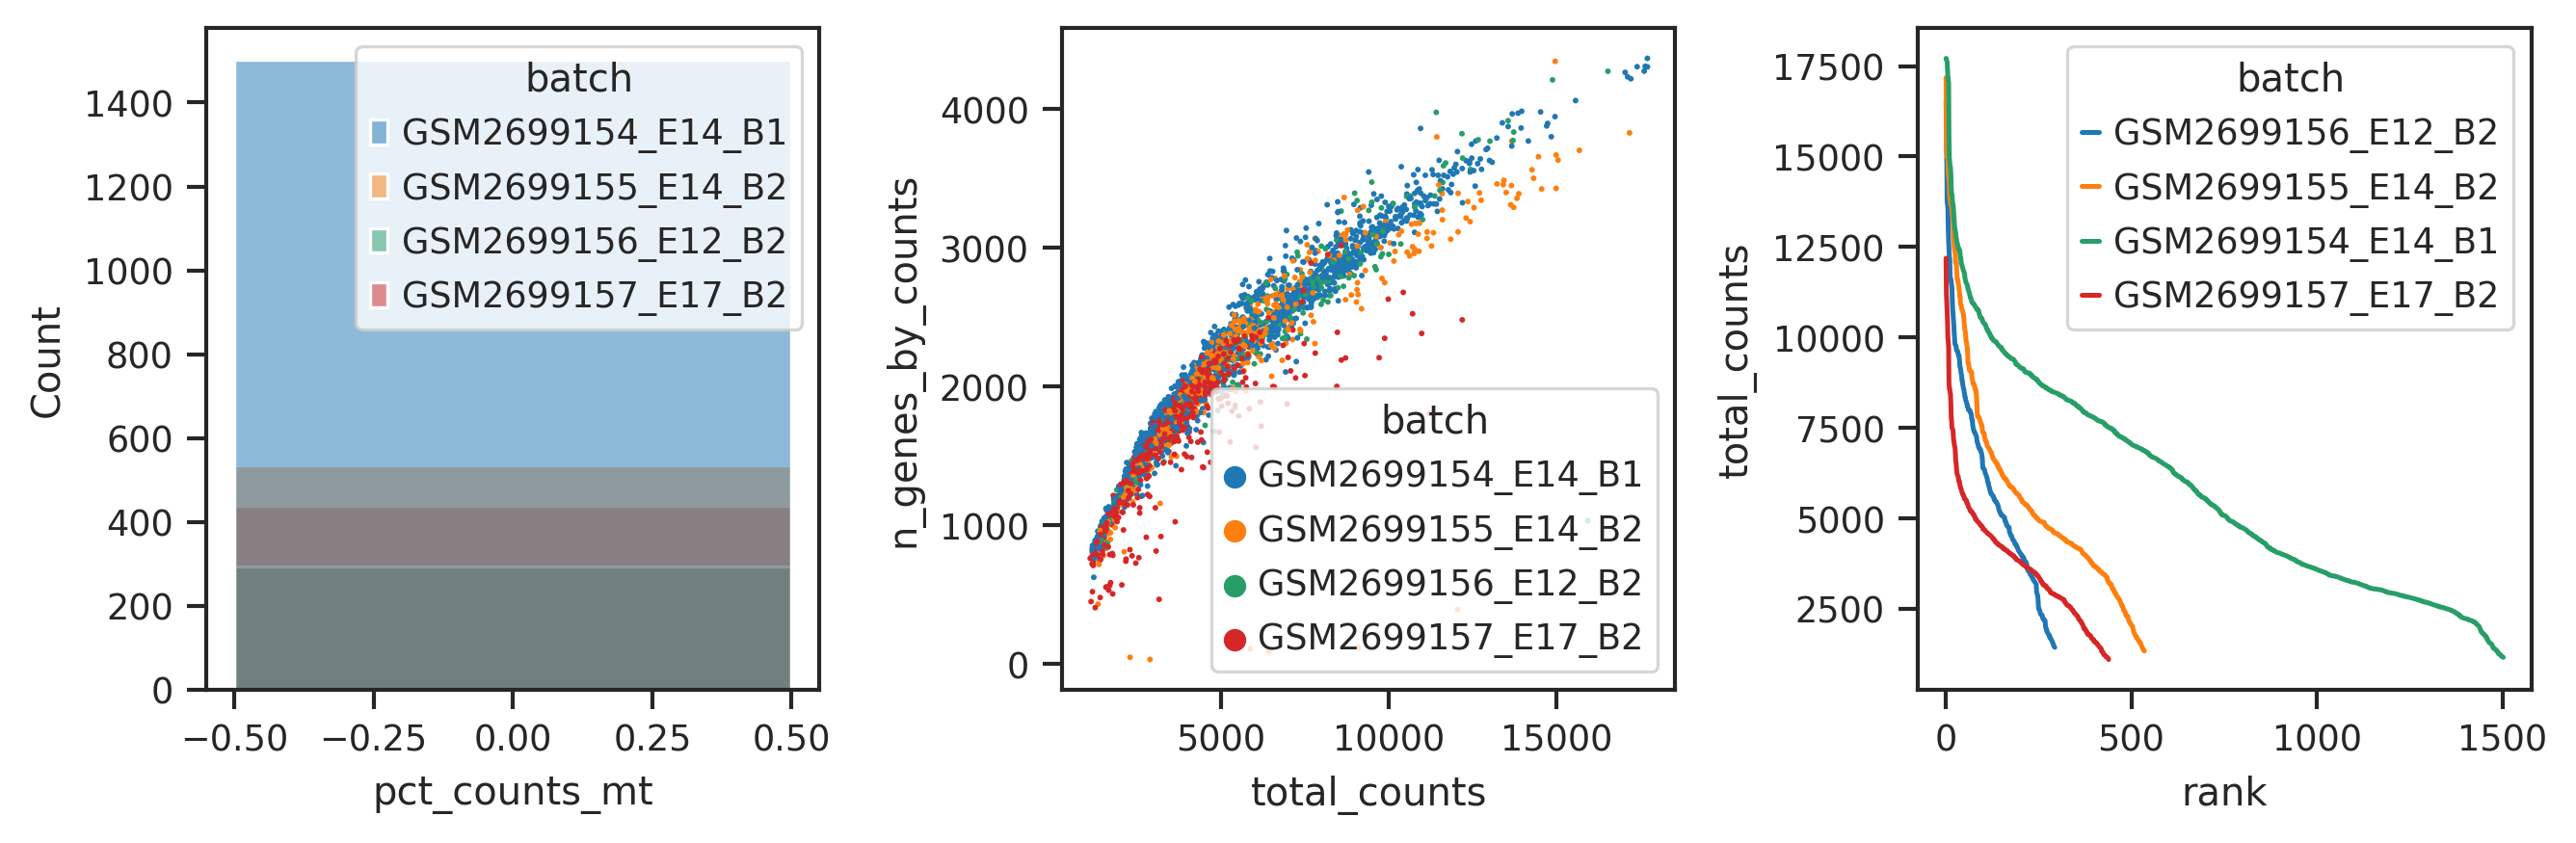

In [39]:
qc_plot(adata, show_thresh=False)

# Create pseudobulk signatures

In [42]:
def create_signature_matrix(adata, obs_key, save_path):
    signatures = pd.DataFrame(index=adata.var_names)
    for cell_type in adata.obs[obs_key].unique():
        signatures[cell_type] = list(pd.DataFrame(adata[adata.obs[obs_key] == cell_type].X.todense()).mean(axis=0))
    signatures.to_csv(save_path)
    return signatures

In [43]:
signatures = create_signature_matrix(adata, "assigned_ident", "/notebook/Joe/M-cells/analysis/cell_type_signatures/pancreatic_epithelium_signatures.csv")

In [44]:
signatures

,Ductal/Acinar,Acinar/Ductal,Ductal,Endocrine-Ngn3,Endocrine,Podocyte-like,Mesenchymal,Immune 2,Acinar,Proliferating,Endothelial,RBCs
,,,,,,,,,,,,
Xkr4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gm1992,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gm37381,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Rp1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sox17,0.006938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
AC168977.1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PISD,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DHRSX,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
signatures = signatures.drop(["Immune 2", "RBCs", "Endothelial"], axis=1)
signatures.columns = signatures.columns + "_pancreatic"
signatures

,Ductal/Acinar_pancreatic,Acinar/Ductal_pancreatic,Ductal_pancreatic,Endocrine-Ngn3_pancreatic,Endocrine_pancreatic,Podocyte-like_pancreatic,Mesenchymal_pancreatic,Acinar_pancreatic,Proliferating_pancreatic
,,,,,,,,,
Xkr4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gm1992,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gm37381,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Rp1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sox17,0.006938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
AC168977.1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PISD,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DHRSX,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
signatures.to_csv("/notebook/Joe/M-cells/analysis/cell_type_signatures/pancreatic_epithelium_signatures.csv")